## Notes

### TODO
- Reboot rover on battery power
- Generate new calibration file and store somewhere accessible from this notebook
- Finalize run_serial_buffer_test_3() so it loads calibration file
- Rerun Experiments 1 and 2 with and without calibration
- Finalize test script for Experiment 3
 - Spawn additional process for simple scripted driving after IMU process is started

### Overview
This notebook captures a series of tests performed on the Raspberry Pi 2 with the Adafruit BNO055 9-dof IMU sensor board.  The main goals for the tests were: 
- characterize the raw and filtered IMU measurements under a variety of platform conditions (e.g., stationary, constant linear motion, etc.)

### READ THIS BEFORE RUNNING
- Some of the following experiments depend on the PIGPIO daemon.  To activate the daemon process, execute the following command on the host machine for this notebook: "sudo pigpiod" (Note: This should be done before running the experiment cells that depend on it.)

### Implementation Details
- The implementation of the underlying periodic wakeups and serial communications were prototyped and documented in the following notebook: sandboxes/ipython_notebooks/imu_sample_rate_tests_3.ipynb
- The implementation of the syncronized Producer-Consumer, buffered data capture and signal processing where prototyped and documented in the following notebook: sandboxes/ipython_notebooks/imu_multiproc_sampling_and_buffering_test_1.ipynb

### Test Design
- Experiment 1: Stationary platform
- Experiment 2: Arbitrary, hand-held motion
- Experiment 3: Near-constant linear velocity
- Experiment 4: Varied linear accelerations
- Experiment 5: Varied 2-D accelerations
 
### Conclusions

### Next Steps


## Component Code

In [1]:
%matplotlib inline
from __future__ import division
import time
import sys
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
CALIBRATION_FILE='../peripherals/bno055_imu/calibration/calibration.json'

BNO_AXIS_REMAP = {
        'x': BNO055.AXIS_REMAP_X,
        'y': BNO055.AXIS_REMAP_Z,
        'z': BNO055.AXIS_REMAP_Y,
        'x_sign': BNO055.AXIS_REMAP_POSITIVE,
        'y_sign': BNO055.AXIS_REMAP_POSITIVE,
        'z_sign': BNO055.AXIS_REMAP_NEGATIVE }

In [38]:
rover1_path = '/home/pi/nanibot/rover1'
if rover1_path not in sys.path:
    sys.path.insert(0,rover1_path)
sys.path

['/home/pi/nanibot/rover1',
 '',
 '/usr/local/lib/python2.7/dist-packages/Adafruit_BNO055-1.0.1-py2.7.egg',
 '/usr/local/lib/python2.7/dist-packages/Adafruit_GPIO-1.0.0-py2.7.egg',
 '/usr/local/lib/python2.7/dist-packages/Adafruit_PureIO-0.2.0-py2.7.egg',
 '/usr/lib/python2.7/dist-packages',
 '/usr/lib/python2.7',
 '/usr/lib/python2.7/plat-arm-linux-gnueabihf',
 '/usr/lib/python2.7/lib-tk',
 '/usr/lib/python2.7/lib-old',
 '/usr/lib/python2.7/lib-dynload',
 '/usr/local/lib/python2.7/dist-packages',
 '/usr/lib/python2.7/dist-packages/gtk-2.0',
 '/usr/lib/pymodules/python2.7',
 '/usr/local/lib/python2.7/dist-packages/IPython/extensions',
 '/home/pi/.ipython']

In [44]:
from Adafruit_BNO055 import BNO055
import serial
from serial.serialutil import SerialException

class BNO055_2(BNO055.BNO055):
    def __init__(self, rst=None, address=BNO055.BNO055_ADDRESS_A, i2c=None, gpio=None,
                 serial_port=None, serial_timeout_sec=5, baudrate=115200, 
                 max_send_attempts=5, **kwargs):
        # If reset pin is provided save it and a reference to provided GPIO
        # bus (or the default system GPIO bus if none is provided).
        self._rst = rst
        if self._rst is not None:
            if gpio is None:
                import Adafruit_GPIO as GPIO
                gpio = GPIO.get_platform_gpio()
            self._gpio = gpio
            # Setup the reset pin as an output at a high level.
            self._gpio.setup(self._rst, GPIO.OUT)
            self._gpio.set_high(self._rst)
            # Wait a 650 milliseconds in case setting the reset high reset the chip.
            time.sleep(0.65)
        self._max_send_attempts=max_send_attempts
        self._serial = None
        self._i2c_device = None
        if serial_port is not None:
            # Use serial communication if serial_port name is provided.
            # Open the serial port at 115200 baud, 8N1.  Add a 5 second timeout
            # to prevent hanging if device is disconnected.
            self._serial = serial.Serial(serial_port, baudrate, timeout=serial_timeout_sec,
                                         writeTimeout=serial_timeout_sec)
        else:
            raise AttributeError('No valid serial interface specified.')
        # - Brief pause to make sure everything finishes initializing (maybe not necessary)
        time.sleep(0.001)
        
    def _serial_send(self, command, ack=True, max_attempts=5):
        # Send a serial command and automatically handle if it needs to be resent
        # because of a bus error.  If ack is True then an ackowledgement is
        # expected and only up to the maximum specified attempts will be made
        # to get a good acknowledgement (default is 5).  If ack is False then
        # no acknowledgement is expected (like when resetting the device).
        attempts = 0
        while True:
            # Flush any pending received data to get into a clean state.
            self._serial.flushInput()
            # Send the data.
            self._serial.write(command)
            #logger.debug('Serial send: 0x{0}'.format(binascii.hexlify(command)))
            # Stop if no acknowledgment is expected.
            if not ack:
                return
            # Read acknowledgement response (2 bytes).
            resp = bytearray(self._serial.read(2))
            #logger.debug('Serial receive: 0x{0}'.format(binascii.hexlify(resp)))
            if resp is None or len(resp) != 2:
                raise RuntimeError('Timeout waiting for serial acknowledge, is the BNO055 connected?')
            # Stop if there's no bus error (0xEE07 response) and return response bytes.
            if not (resp[0] == 0xEE and resp[1] == 0x07):
                return resp
            # Else there was a bus error so resend, as recommended in UART app
            # note at:
            #   http://ae-bst.resource.bosch.com/media/products/dokumente/bno055/BST-BNO055-AN012-00.pdf
            attempts += 1
            if attempts >=  self._max_send_attempts:
                raise RuntimeError('Exceeded maximum attempts to acknowledge serial command without bus error!')

In [3]:
def wakeup_handler(signum, frame):
    global wakeup_set, wakeup_wrap
    if wakeup_set:
        wakeup_wrap = True
    wakeup_set = True

def initialize_sensor_itimer(wakeup_interval_usec):
    import signal
    # Define sigaction for SIGALRM
    signal.signal(signal.SIGALRM,wakeup_handler)
    signal.setitimer(signal.ITIMER_REAL,wakeup_interval_usec*1e-6,wakeup_interval_usec*1e-6)
    
def cleanup_itimer():
    import signal
    signal.setitimer(signal.ITIMER_REAL,0,0)

def finalize_wakeup_attempt():
    global wakeup_set, wakeup_count, read_started, read_completed
    wakeup_set = False
    wakeup_count += 1
    read_started = False
    read_completed = True
    

In [45]:
def run_serial_buffer_test_3(
    num_samples, 
    sample_interval_usec, 
    max_read_retries, 
    t_array,
    x_array, 
    y_array, 
    z_array,
    buffer_offset,
    buffer_full_condition,
    buffer_mutex):
    
    # Reset global variables (Probably necessary for repeated runs in iPython)
    global wakeup_count, wakeup_set, read_started, read_completed, wakeup_wrap
    wakeup_count = 0
    wakeup_set = 0
    read_started = 0
    read_completed = 0
    wakeup_wrap = 0
    
    # Compute operational constants
    max_time_sec = 10 * num_samples * sample_interval_usec * 1.0e-6 # Extra factor of 10, so we don't get cutoff prematurely

    
    # -- Create serial adapter and initialize BNO055 sensor --
    imu = BNO055_2(
        serial_port='/dev/ttyAMA0', 
        rst=18, 
        baudrate=115200,
        max_send_attempts=max_read_retries)
    # -- Reset bno and set to desired mode --
    mode = BNO055.OPERATION_MODE_NDOF
    #mode = BNO055.OPERATION_MODE_AMG
    #mode = BNO055.OPERATION_MODE_GYRONLY
    
    # Load calibration from disk.
    with open(CALIBRATION_FILE, 'r') as cal_file:
        cal_data = json.load(cal_file)
    
    if not imu.begin(mode=mode):
        raise RuntimeError('Failed to initialize BNO055!')
    if axis_remap is not None:
        imu.set_axis_remap(**BNO_AXIS_REMAP)
    if calibration_data is not None:
        imu.set_calibration(cal_data)
    
    # - Repeatedly Pole Sensor until end of test
    loop_count, success_count, comm_fail_count = 0,0,0
    wrap_count, max_comm_fail_count = 0,0
    duration, heartbeat_duration = 0,0
    
    # Initialize buffer management
    buffer_size = len(t_array)
    print 'buffer_size: ',buffer_size
    
    # Initialize timers
    start_time = time.time()
    heartbeat_time = start_time
    
    try:
        # Initialize the interupt timer for periodic wakeups
        initialize_sensor_itimer(wakeup_interval_usec=sample_interval_usec)
        
        while True:
            loop_count+=1        
            if (loop_count % 100) == 0:
                current_time = time.time()
                duration = current_time - start_time
                if duration >= max_time_sec:
                    raise ValueError('Max program duration exceeded')
            if (loop_count > 100*1e6):
                raise ValueError('Max program loop count exceeded')
            if (wakeup_count > num_samples):
                raise ValueError('Max read attempts exceeded')
            
            # - Come in here if a scheduled wakeup occurred and has not been marked complete (by success or failure)
            if wakeup_set:
                # - Handle wakeup wrap condition
                if wakeup_wrap:
                    wakeup_wrap = False
                    wrap_count += 1
                    finalize_wakeup_attempt()
                    # In the case of wakeup wrap, keep wakeup_set true, but count the failed attempt
                    wakeup_set = True
                    # DEBUG
                    #print 'Wakeup wrap!'
                
                # Indicate that we have started trying to read from the sensor for the current scheduled wakeup
                read_started = 1
                read_completed = 0
        
                # - Attempt to read linear accel (using max_read_retries)
                try:
                    # DEBUG
                    #print 'Buffer offset: ',buffer_offset.value
                    # Get lock for buffers
                    buffer_mutex.acquire()
                    # TODO: This could be improved by implementing as a FIFO that always has the "freshest possible data"
                    if buffer_offset.value < buffer_size:
                        x, y, z = imu.read_linear_acceleration()
                        t_array[buffer_offset.value] = time.time()
                        x_array[buffer_offset.value] = x
                        y_array[buffer_offset.value] = y
                        z_array[buffer_offset.value] = z
                        buffer_offset.value += 1
                        # Notify consumer that full buffer is ready to read
                        if buffer_offset.value >= buffer_size:
                            buffer_full_condition.acquire()
                            buffer_full_condition.notify()
                            buffer_full_condition.release()
                    # Release lock on buffers
                    buffer_mutex.release()
                            
                except RuntimeError as err:
                    print 'Runtime Exception: {}'.format(err)
                    continue
                except SerialException as err:
                    print 'Serial Exception: {}'.format(err)
                    continue
                except:
                    exc_type, exc_value = sys.exc_info()[:2]
                    print 'Unknown exception on wakeup: {0}\n{1}\n{2}'.format(
                        wakeup_count,
                        exc_type,
                        exc_value)
                    print 'about to release lock in child due to exception, buffer offset: ',buffer_offset.value
                    buffer_mutex.release()
                    #raise
                    continue
                
                success_count += 1
                finalize_wakeup_attempt()
    
    except ValueError as err:
        print 'Program ended: {}'.format(err)
    finally:
        cleanup_itimer()
        
    # - Cleanup after main program loop
    print 'Program duration (sec): {:0.1f}'.format(duration)
    print 'Total loop count: {}'.format(loop_count)
    print 'Read attempts: {}'.format(wakeup_count)
    print 'Sensor sample interval (ms): {:0.1f}'.format(sample_interval_usec/1000);
    print 'Successful reads: {}'.format(success_count)
    #printf("Max comm failure occurrences: %d\n",max_comm_fail_count);
    print 'Wakeup wrap count: {}'.format(wrap_count);
    print 'Read success rate: {:0.3f}'.format(success_count/wakeup_count);


## Experiments

In [24]:
def run_buffered_sensor_read_test():
    import multiprocessing as mproc
    import time
    import math

    buffer_size = 10
    num_samples=100
    sample_interval_usec=10000
    max_read_retries=5

    buffer_full_condition = mproc.Condition()
    buffer_mutex = mproc.Lock()

    t_arr = mproc.Array('d', range(buffer_size))
    x_arr = mproc.Array('d', range(buffer_size))
    y_arr = mproc.Array('d', range(buffer_size))
    z_arr = mproc.Array('d', range(buffer_size))
    buffer_offset = mproc.Value('i',0)

    p = mproc.Process(
        target=run_serial_buffer_test_3, 
        args=(
            num_samples,
            sample_interval_usec,
            max_read_retries,
            t_arr,x_arr,y_arr,z_arr,
            buffer_offset,
            buffer_full_condition,
            buffer_mutex))

    launch_start_time = time.time()
    p.start()
    time.sleep(0.5)

    all_times = []
    all_x_data = []
    all_y_data = []
    all_z_data = []
    for sample_ind in range(int(math.floor(num_samples/buffer_size))):
        # Wait for notification buffer is full
        buffer_full_condition.acquire()
        buffer_full_condition.wait(timeout=1)
        # Lock buffers from being modified while copying and resetting
        buffer_mutex.acquire()
        local_t = t_arr[:]
        local_x = x_arr[:]
        local_y = y_arr[:]
        local_z = z_arr[:]
        buffer_offset.value = 0
        # Unlock buffers
        buffer_mutex.release()
        time.sleep(0.5)
        buffer_full_condition.release()
        all_times.append([l_t - launch_start_time for l_t in local_t])
        all_x_data.append(local_x)
        all_y_data.append(local_y)
        all_z_data.append(local_z)
    
    p.join(10)

    return {
        't_data':all_times,
        'x_data':all_x_data,
        'y_data':all_y_data,
        'z_data':all_z_data}

In [30]:
def plot_buffered_sensor_data(test_data,buffer_offset):
    sig_data_x = test_data['x_data'][buffer_offset]
    sig_data_y = test_data['y_data'][buffer_offset]
    sig_data_z = test_data['z_data'][buffer_offset]

    b, a = signal.butter(5, [0.1,0.50], 'bandpass', analog=False)
    filt_data_x = signal.filtfilt(b,a,sig_data_x,padtype='odd',padlen=0)
    filt_data_y = signal.filtfilt(b,a,sig_data_y,padtype='odd',padlen=0)
    filt_data_z = signal.filtfilt(b,a,sig_data_z,padtype='odd',padlen=0)

    fig, axes = plt.subplots(figsize=(8,10),nrows=3, ncols=1)

    current_axes = axes[0]
    current_axes.plot(sig_data_x, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    current_axes.plot(filt_data_x, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - X', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    current_axes.legend(loc='upper right')

    current_axes = axes[1]
    current_axes.plot(sig_data_y, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    current_axes.plot(filt_data_y, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - Y', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    current_axes.legend(loc='upper right')

    current_axes = axes[2]
    current_axes.plot(sig_data_z, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    current_axes.plot(filt_data_z, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - Z', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    current_axes.legend(loc='upper right')

### Experiment 1: Static platform

In [32]:
test_data = run_buffered_sensor_read_test()
# Generate some output for debugging
print 'all measurement times:'
for buff_time in test_data['t_data']:
    print '\t'.join(['{:.3f}'.format(t_str) for t_str in buff_time])

buffer_size:  10
Program ended: Max read attempts exceeded
Program duration (sec): 4.2
Total loop count: 69031
Read attempts: 101
Sensor sample interval (ms): 10.0
Successful reads: 92
Wakeup wrap count: 9
Read success rate: 0.911
all measurement times:
1.081	1.092	1.103	1.112	1.122	1.132	1.142	1.152	1.163	1.172
1.182	1.192	1.203	1.213	1.222	1.232	1.242	1.252	1.264	1.272
1.694	1.704	1.717	1.724	1.734	1.744	1.754	1.767	1.775	1.785
2.192	2.203	2.212	2.222	2.233	2.242	2.252	2.262	2.272	2.282
2.692	2.703	2.712	2.724	2.732	2.742	2.752	2.762	2.774	2.782
3.194	3.205	3.215	3.227	3.235	3.245	3.255	3.265	3.278	3.285
3.692	3.703	3.712	3.722	3.732	3.742	3.752	3.762	3.772	3.782
4.203	4.212	4.222	4.234	4.242	4.252	4.262	4.272	4.285	4.292
4.705	4.715	4.725	4.738	4.745	4.755	4.765	4.775	4.788	4.796
5.204	5.212	4.725	4.738	4.745	4.755	4.765	4.775	4.788	4.796


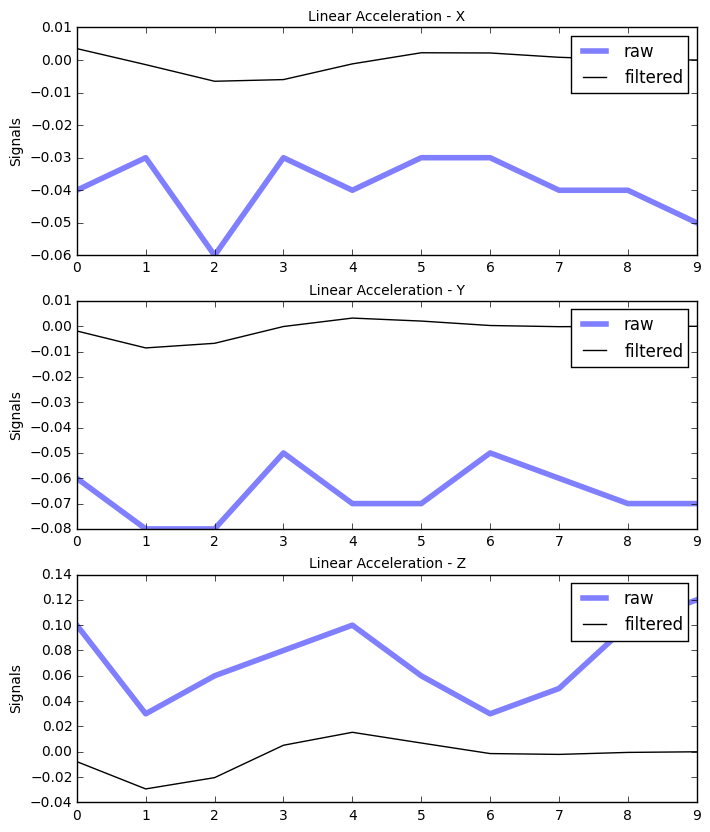

In [33]:
plot_buffered_sensor_data(test_data,0)

### Experiment 2: Manual arbitrary movement

In [34]:
test_data = run_buffered_sensor_read_test()
# Generate some output for debugging
print 'all measurement times:'
for buff_time in test_data['t_data']:
    print '\t'.join(['{:.3f}'.format(t_str) for t_str in buff_time])

buffer_size:  10
Program ended: Max read attempts exceeded
Program duration (sec): 4.2
Total loop count: 65687
Read attempts: 101
Sensor sample interval (ms): 10.0
Successful reads: 92
Wakeup wrap count: 9
Read success rate: 0.911
all measurement times:
0.938	0.953	0.961	0.972	0.981	0.997	1.002	1.011	1.021	1.031
1.041	1.051	1.061	1.071	1.081	1.091	1.102	1.112	1.121	1.131
1.541	1.551	1.561	1.574	1.581	1.591	1.601	1.612	1.624	1.631
2.044	2.054	2.065	2.077	2.084	2.095	2.105	2.115	2.128	2.135
2.551	2.561	2.572	2.581	2.591	2.601	2.611	2.621	2.631	2.641
3.052	3.062	3.072	3.084	3.092	3.102	3.112	3.122	3.134	3.142
3.555	3.565	3.575	3.588	3.595	3.605	3.615	3.625	3.632	3.642
4.052	4.061	4.072	4.081	4.091	4.102	4.112	4.121	4.131	4.141
4.562	4.572	4.582	4.595	4.603	4.612	4.622	4.633	4.645	4.652
5.065	5.075	4.582	4.595	4.603	4.612	4.622	4.633	4.645	4.652


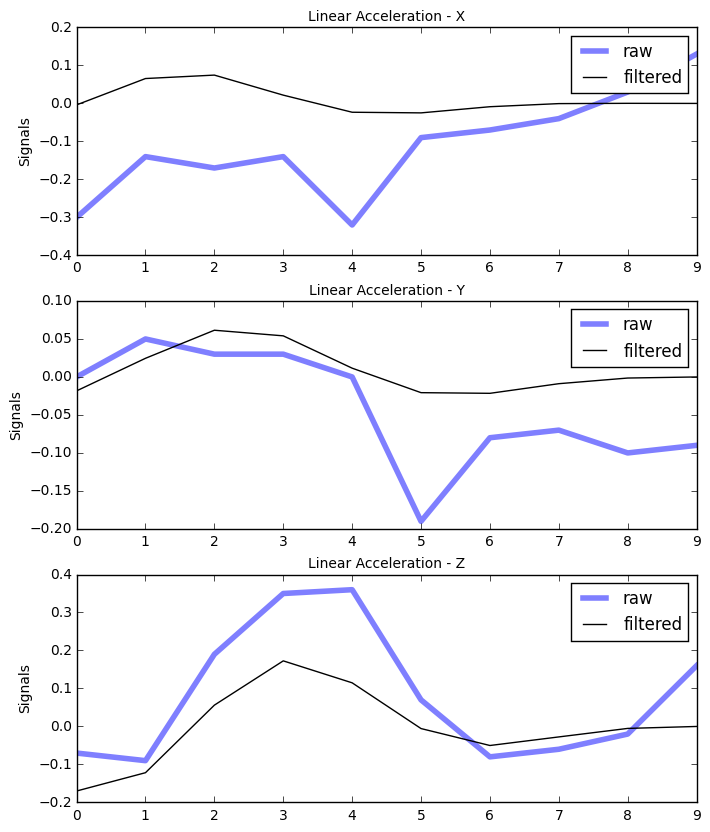

In [36]:
plot_buffered_sensor_data(test_data,1)

## Sandbox

In [171]:
p.is_alive()

False

In [110]:
p.join()

In [198]:
%matplotlib inline
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

numerator:  [ 0.0527864   0.26393202  0.52786405  0.52786405  0.26393202  0.0527864 ]
denominator:  [  1.00000000e+00  -4.16333634e-16   6.33436854e-01  -1.31860534e-16
   5.57280900e-02  -3.09353043e-18]


(-500, 50)

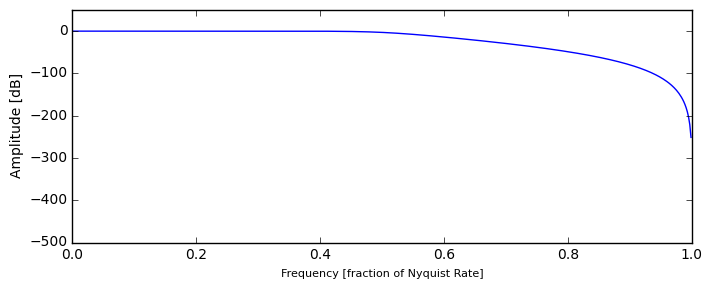

In [216]:
b, a = signal.butter(5, 0.5, 'low', analog=False)
w, h = signal.freqz(b,a)

print 'numerator: ',b
print 'denominator: ',a

fig, axes = plt.subplots(figsize=(8,3),nrows=1, ncols=1)
current_axes = axes
current_axes.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
current_axes.set_ylabel('Amplitude [dB]', fontsize=10)
current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
current_axes.set_ylim([-500,50])

numerator:  [ 0.7753166   3.87658298  7.75316595  7.75316595  3.87658298  0.7753166 ]
denominator:  [ 1.          4.49183097  8.09405542  7.31208128  3.31104756  0.60111582]


(-500, 50)

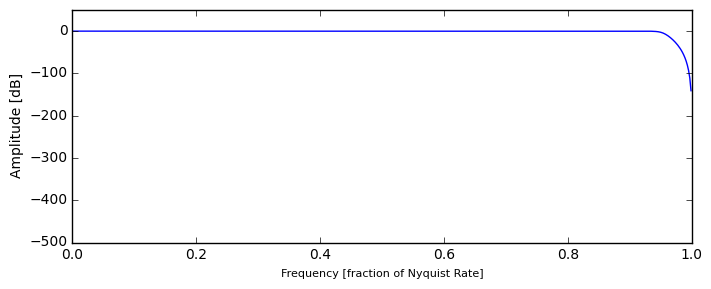

In [218]:
b, a = signal.butter(5, 0.95, 'low', analog=False)
w, h = signal.freqz(b,a)

print 'numerator: ',b
print 'denominator: ',a

fig, axes = plt.subplots(figsize=(8,3),nrows=1, ncols=1)
current_axes = axes
current_axes.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
current_axes.set_ylabel('Amplitude [dB]', fontsize=10)
current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
current_axes.set_ylim([-500,50])

numerator:  [ 0.5999402   0.         -2.99970102  0.          5.99940204  0.
 -5.99940204  0.          2.99970102  0.         -0.5999402 ]
denominator:  [  1.00000000e+00  -1.77635684e-15  -3.98454312e+00   2.66453526e-15
   6.43486709e+00  -7.10542736e-15  -5.25361517e+00  -1.11022302e-15
   2.16513291e+00  -3.33066907e-16  -3.59928245e-01]


(-500, 50)

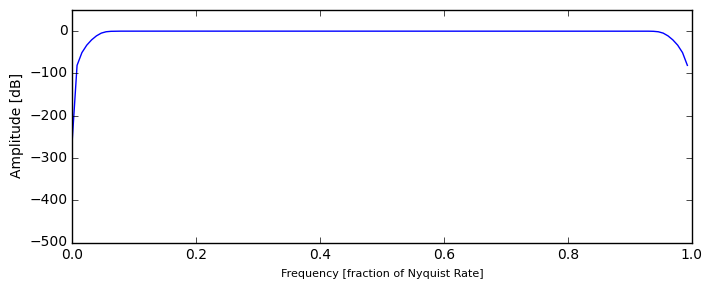

In [238]:
b, a = signal.butter(5, [0.05,0.95], 'bandpass', analog=False)
w, h = signal.freqz(b,a,128)

print 'numerator: ',b
print 'denominator: ',a

fig, axes = plt.subplots(figsize=(8,3),nrows=1, ncols=1)
current_axes = axes
current_axes.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
current_axes.set_ylabel('Amplitude [dB]', fontsize=10)
current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
current_axes.set_ylim([-500,50])

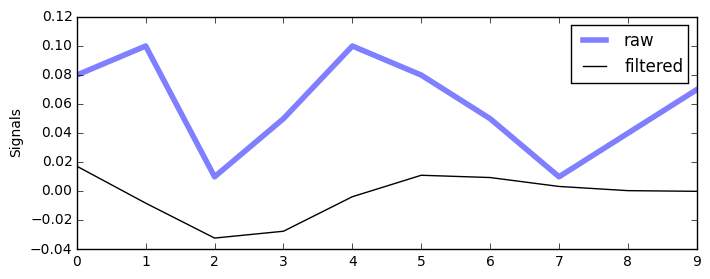

In [267]:
#sig_data = all_x_data[0]
#sig_data = all_y_data[0]
sig_data = all_z_data[0]

b, a = signal.butter(5, [0.1,0.50], 'bandpass', analog=False)
filt_data = signal.filtfilt(b,a,sig_data,padtype='odd',padlen=0)
#b, a = signal.butter(5, [0.95], 'low', analog=False)
#filt_data = signal.filtfilt(b,a,sig_data,padtype='odd',padlen=0)
#b, a = signal.butter(5, [0.05], 'high', analog=False)
#filt_data = signal.filtfilt(b,a,sig_data,padtype='odd',padlen=0)

fig, axes = plt.subplots(figsize=(8,3),nrows=1, ncols=1)
current_axes = axes
current_axes.plot(sig_data, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
current_axes.plot(filt_data, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
current_axes.set_ylabel('Signals', fontsize=10)
current_axes.legend(loc='upper right')
#current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
#current_axes.set_ylim([-500,50])

In [40]:
import peripherals.sabertooth.sabertooth_adapter as sabertooth_adapter
import components.driving.motor_control as motor_control

In [42]:
motorControllerAdapter = sabertooth_adapter.SabertoothPacketizedAdapterGPIO()
motorController = motor_control.MotorController(motorControllerAdapter)

motor command:  131   2   10   15


In [43]:
def drive_test_1(default_speed=10):
    import peripherals.sabertooth.sabertooth_adapter as sabertooth_adapter
    import components.driving.motor_control as motor_control
    
    try:
        motorControllerAdapter = sabertooth_adapter.SabertoothPacketizedAdapterGPIO()
        motorController = motor_control.MotorController(motorControllerAdapter)
        
        start_time = time.time()
        
        motorController.goForward(default_speed)
        motorController.goStraight()
        
        time.sleep(2)
        
        motorControllerAdapter.stop()
        
        # Increase speed 5%
        #motorController.adjustFwdBwdSetting(5)
        
    finally:
        motorControllerAdapter.stop()
        time.sleep(2)